<h1><a style="float: left;" target="_blank" href="https://www.couchbase.com/"><img style="height: 40px; margin-right: 20px;" src="https://softwarereviews.s3.amazonaws.com/production/favicons/offerings/4476/original/Couchbase-logo.png" /></a><span style="display: inline-block;">Airline Passenger Satisfaction Workshop</span></h1>
<div style="padding-bottom: 20px;"><b>October 2023</b></div>
<h2>Scenario</h2>
<div style="display: flex;">
    <div style="flex: 50%; text-align: center;">
        <img src="images/architecture.png">
    </div>
    <div style="flex: 50%; padding-right: 100px;">
        <p>You are a Data Scientist! Your Aviation Company has just started using the Couchbase Data Platform for the new Mobile Aviation Application that will be rolled out to all of your passengers.</p>
        <p>The old Mobile Aviation Application used to not respond when passengers were not connected to the internet and the data collected was incomplete. The passengers were not very happy with the application.</p>
        <p>The new application can now capture all of the information locally using Couchbase Lite on the mobile device and sync the information into your Couchbase Capella database.</p>
        <p>You have been asked to create a prediction model that will classify passengers as either Satisfied or Neutral / Dissatisfied with the service of the company.</p>
        <p>
            <dl>
                <dt><h4>Survey Data</h4></dt>
                <dd><b>Gender:</b> male or female</dd>
                <dd><b>Customer Type:</b> regular or non-regular airline customer</dd>
                <dd><b>Age:</b> the actual age of the passenger</dd>
                <dd><b>Type of travel:</b> the purpose of the passenger's flight (personal or business travel)</dd>
                <dd><b>Class:</b> business, economy, economy plus</dd>
                <dd><b>Flight distance</b></dd>
                <dd><b>Inflight wifi service:</b> satisfaction level with Wi-Fi service on board (0: not rated; 1-5)</dd>
                <dd><b>Departure/Arrival time convenient:</b> departure/arrival time satisfaction level (0: not rated; 1-5)</dd>
                <dd><b>Ease of Online booking:</b> online booking satisfaction rate (0: not rated; 1-5)</dd>
                <dd><b>Gate location:</b> level of satisfaction with the gate location (0: not rated; 1-5)</dd>
                <dd><b>Food and drink:</b> food and drink satisfaction level (0: not rated; 1-5)</dd>
                <dd><b>Online boarding:</b> satisfaction level with online boarding (0: not rated; 1-5)</dd>
                <dd><b>Seat comfort:</b> seat satisfaction level (0: not rated; 1-5)</dd>
                <dd><b>Inflight entertainment:</b> satisfaction with inflight entertainment (0: not rated; 1-5)</dd>
                <dd><b>On-board service:</b> level of satisfaction with on-board service (0: not rated; 1-5)</dd>
                <dd><b>Leg room service:</b> level of satisfaction with leg room service (0: not rated; 1-5)</dd>
                <dd><b>Baggage handling:</b> level of satisfaction with baggage handling (0: not rated; 1-5)</dd>
                <dd><b>Checkin service:</b> level of satisfaction with checkin service (0: not rated; 1-5)</dd>
                <dd><b>Inflight service:</b> level of satisfaction with inflight service (0: not rated; 1-5)</dd>
                <dd><b>Cleanliness:</b> level of satisfaction with cleanliness (0: not rated; 1-5)</dd>
                <dd><b>Departure delay in minutes</b></dd>
                <dd><b>Arrival delay in minutes</b></dd>
            </dl>
        </p>
    </div>
</div>

## Install Libraries

In [2]:
!python3 -m pip install --upgrade pip
!python3 -m pip install scikit-learn
!python3 -m pip install seaborn
!python3 -m pip install couchbase

## Import Classes

In [3]:
# Couchbase
from datetime import timedelta
import traceback
from couchbase.exceptions import CouchbaseException
from couchbase.auth import PasswordAuthenticator
from couchbase.cluster import Cluster
from couchbase.options import ClusterOptions

# SKLearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Download Data

In [4]:
# data = pd.read_csv("data/train.csv")

endpoint = "<<connection string>>" # Replace this with Connection String
username = "demo" # Replace this with username from database access credentials
password = "<<password>>" # Replace this with password from database access credentials
bucket_name = "passenger"
scope_name = "survey"
collection_name = "satisfaction"
data = pd.DataFrame()
# Connect options - authentication
auth = PasswordAuthenticator(username, password)
# Get a reference to our cluster
options = ClusterOptions(auth)
# Use the pre-configured profile below to avoid latency issues with your connection.
options.apply_profile("wan_development")
try:
    cluster = Cluster(endpoint, options)
    # Wait until the cluster is ready for use.
    cluster.wait_until_ready(timedelta(seconds=5))
    data = pd.json_normalize(cluster.query("SELECT * FROM " + bucket_name + "." + scope_name + "." + collection_name))
    data.columns = data.columns.str.replace(collection_name + '.', '')
except Exception as e:
    traceback.print_exc()

Table dimensions:

In [5]:
data.shape

(103904, 25)

Each row corresponds to one passenger, and each column to a specific feature.<br>
Let's look at the first and last rows of the data set:

In [6]:
data.head()

,index,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [7]:
data.tail()

,index,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
103899,103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,...,2,3,1,4,2,3,2,3,0.0,neutral or dissatisfied
103900,103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,...,5,5,5,5,5,5,4,0,0.0,satisfied
103901,103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,...,4,3,2,4,5,5,4,7,14.0,neutral or dissatisfied
103902,103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,...,1,4,5,1,5,4,1,0,0.0,neutral or dissatisfied
103903,103903,62567,Male,Loyal Customer,27,Business travel,Business,1723,1,3,...,1,1,1,4,4,3,1,0,0.0,neutral or dissatisfied


Let's take a closer look at the dataset data:

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   index                              103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

You may notice the following:
<ol>
     <li><b>The column</b> corresponding to the <b>Arrival Delay in Minutes feature has 310 missing values</b>.</dd>
     <li><b>The id and index features are useless and will not affect the classification</b>, so you should get rid of them.</dd>
     <li><b>Many columns contain categorical values</b> but are of type 'object' or 'int64'. Let's replace this type with a special one designed for storing categorical values.</dd>
</ol>

In [9]:
data = data.drop(["index","id"], axis = 1)

In [10]:
categories = ["Gender","Customer Type","Type of Travel","Class","Inflight wifi service","Departure/Arrival time convenient","Ease of Online booking","Gate location","Food and drink","Online boarding","Seat comfort","Inflight entertainment","On-board service","Leg room service","Baggage handling","Checkin service","Inflight service","Cleanliness"]
data[categories] = data[categories].astype('category')
floats = ["Departure Delay in Minutes","Arrival Delay in Minutes"]
data[floats] = data[floats].astype('float64')

Now the dataset information looks like this:

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             103904 non-null  category
 1   Customer Type                      103904 non-null  category
 2   Age                                103904 non-null  int64   
 3   Type of Travel                     103904 non-null  category
 4   Class                              103904 non-null  category
 5   Flight Distance                    103904 non-null  int64   
 6   Inflight wifi service              103904 non-null  category
 7   Departure/Arrival time convenient  103904 non-null  category
 8   Ease of Online booking             103904 non-null  category
 9   Gate location                      103904 non-null  category
 10  Food and drink                     103904 non-null  category
 11  Online boarding           

The first 22 features have been detailed above. The <b>satisfaction</b> feature is the target.

## Data Visualization and Calculation of the Main Characteristics

Get summary information about quantitative features by calling the "describe" method with default parameters:

In [12]:
data.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103594.000000
mean,39.379706,1189.448375,14.815618,15.178678
std,15.114964,997.147281,38.230901,38.698682
min,7.000000,31.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000
50%,40.000000,843.000000,0.000000,0.000000
75%,51.000000,1743.000000,12.000000,13.000000
max,85.000000,4983.000000,1592.000000,1584.000000


For each quantitative attribute, mean values, standard deviation, minimum and maximum values, median and quartile values are given.

Now we get information about categorical features:

In [13]:
data.describe(include = ['category'])

,Gender,Customer Type,Type of Travel,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
count,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904,103904
unique,2,2,2,3,6,6,6,6,6,6,6,6,6,6,5,6,6,6
top,Female,Loyal Customer,Business travel,Business,3,4,3,3,4,4,4,4,4,4,4,4,4,4
freq,52727,84923,71655,49665,25868,25546,24449,28577,24359,30762,31765,29423,30867,28789,37383,29055,37945,27179


For each categorical feature, the total number of values, the number of unique values, the most frequently occurring element and the total number of such elements are given.

Let's look at the ratio of the values of the target variable:

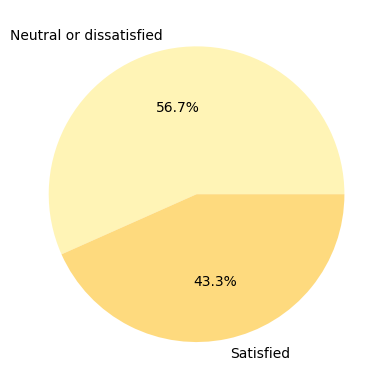

In [14]:
plt.pie(data.satisfaction.value_counts(), labels = ["Neutral or dissatisfied", "Satisfied"], colors = sns.color_palette("YlOrBr"), autopct = '%1.1f%%')
pass

As you can see from the pie chart, <b>the selection is more or less balanced</b>.

Let's calculate the correlation matrix for quantitative features and use the visual image of this matrix:

In [15]:
corr_mat = data.loc[:,["Age","Arrival Delay in Minutes","Departure Delay in Minutes","Flight Distance"]].corr()
corr_mat

,Age,Arrival Delay in Minutes,Departure Delay in Minutes,Flight Distance
Age,1.000000,-0.012147,-0.010152,0.099461
Arrival Delay in Minutes,-0.012147,1.000000,0.965481,-0.002426
Departure Delay in Minutes,-0.010152,0.965481,1.000000,0.002158
Flight Distance,0.099461,-0.002426,0.002158,1.000000


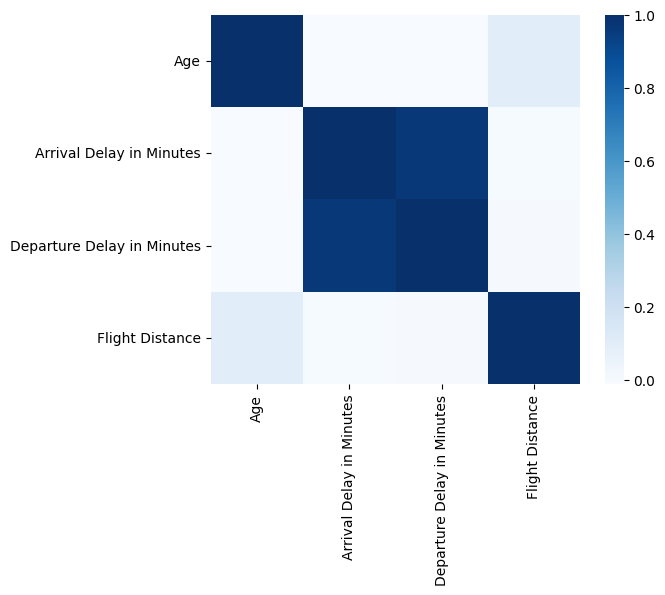

In [16]:
sns.heatmap(corr_mat, square = True, cmap = 'Blues')
pass

You can see that there is a strong correlation between the features <em>'Departure delay in minutes'</em> and <em>'Arrival delay in minutes'</em>. The value of the correlation coefficient reaches the following value:

In [17]:
corr_mat.where(np.triu(corr_mat > 0.5, k=1)).stack().sort_values(ascending = False)

Arrival Delay in Minutes  Departure Delay in Minutes    0.965481
dtype: float64

Let's build a scatterplot for these features:

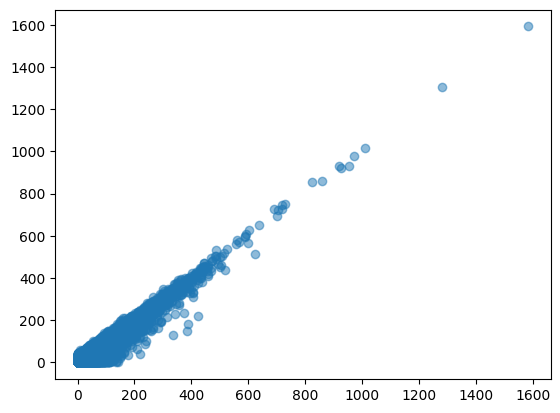

In [18]:
plt.scatter(data['Arrival Delay in Minutes'], data['Departure Delay in Minutes'], alpha = 0.5)
pass

You can see that the points lined up more or less along a straight line going from the lower left corner to the upper right. Thus, in some approximation <b>the dependence of the arrival time delay on the departure time delay is linear</b>.

The results obtained are quite logical and can be explained as follows. If the flight of the airline's customers was delayed by a certain amount of time at departure, then the flight will be delayed by about the same amount of time at landing (provided that the aircraft does not accelerate in flight to make up for lost time).

Consider the ratio of values for each of the categorical features:

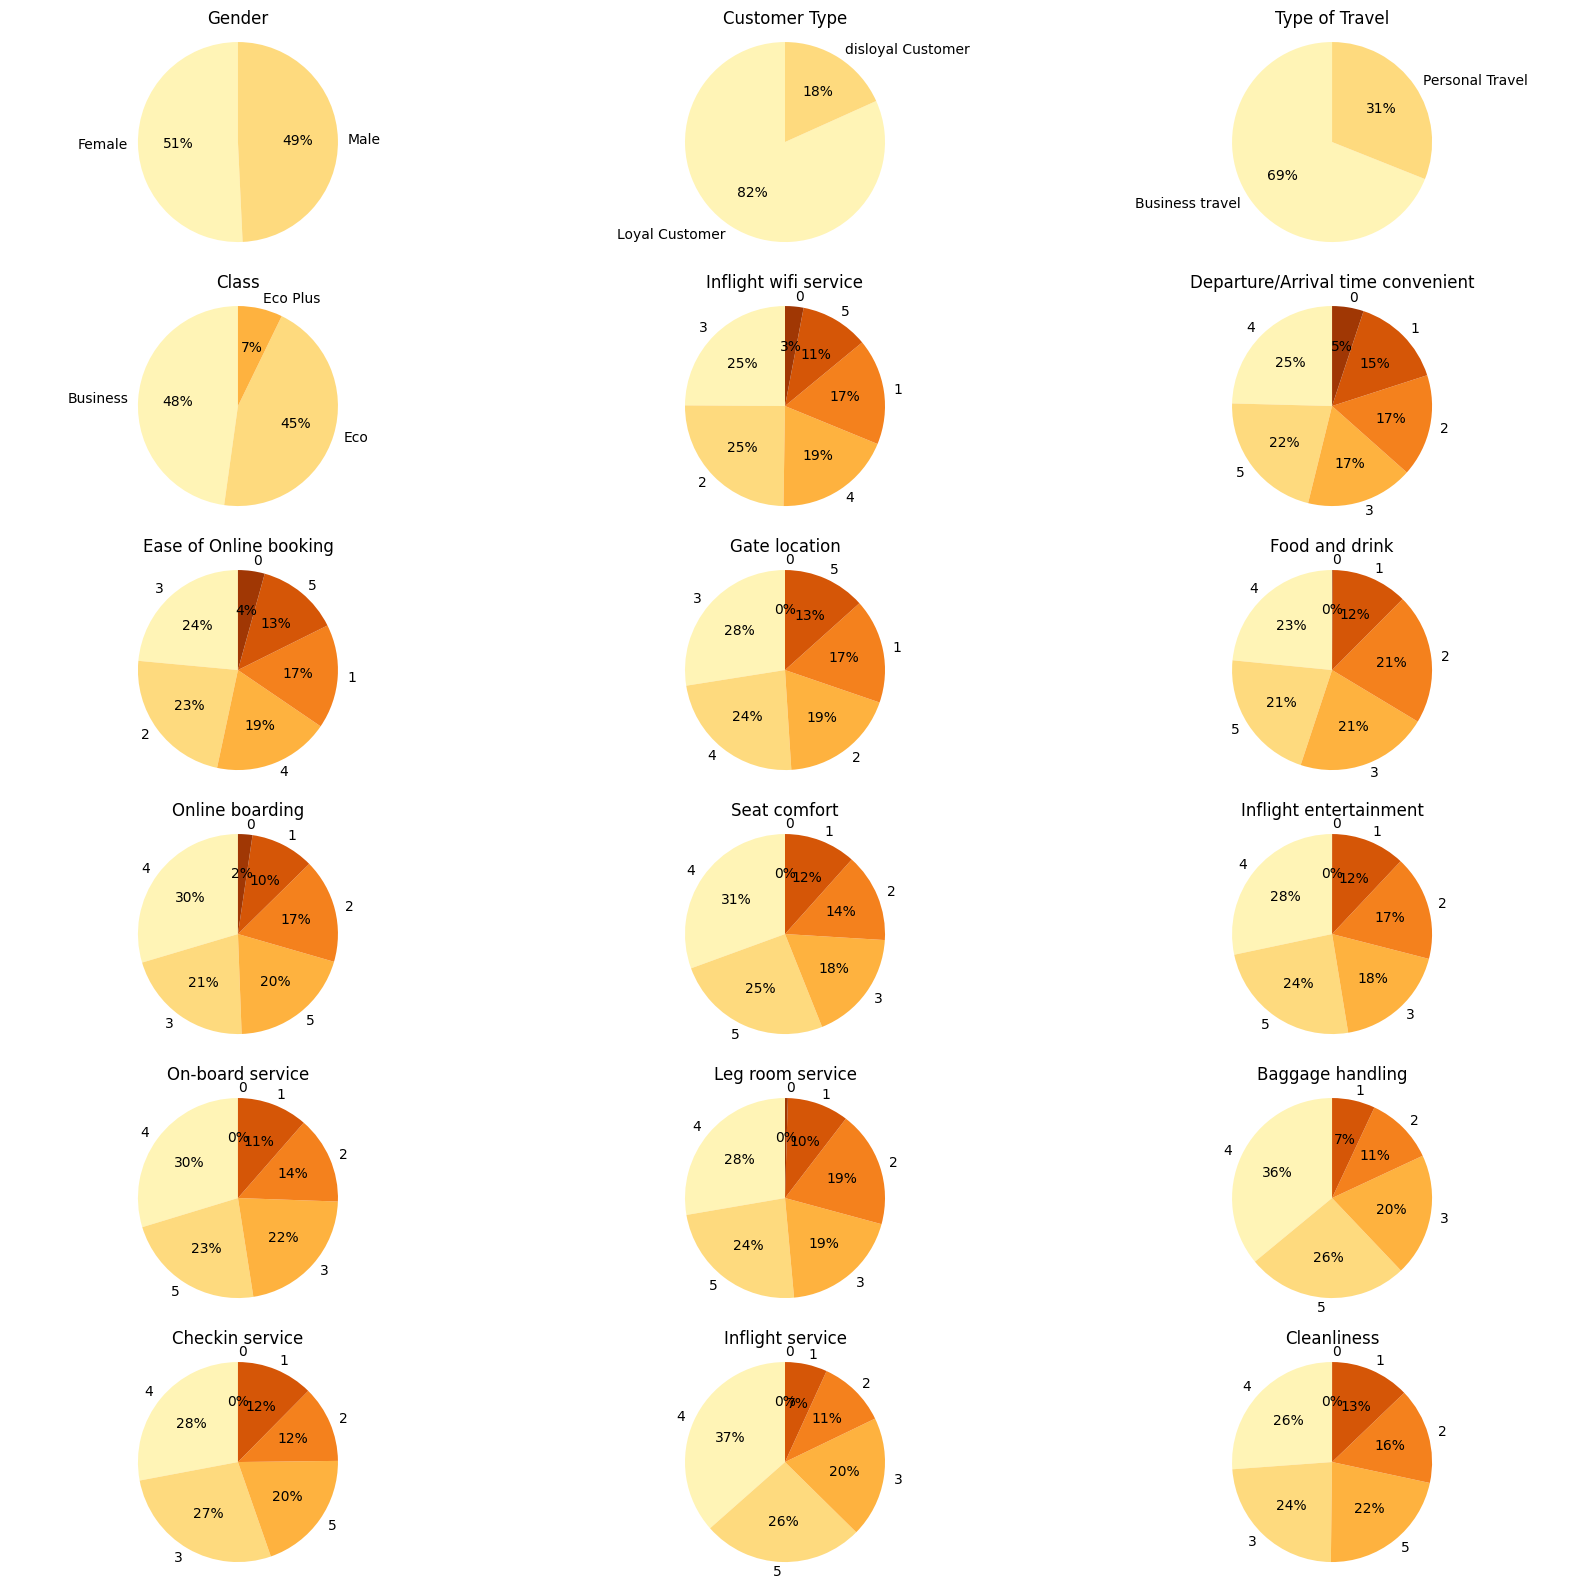

In [19]:
categ = data[categories]
fig, axes = plt.subplots(6, 3, figsize = (20, 20))
for i, col in enumerate(categ):
    column_values = data[col].value_counts()
    labels = column_values.index
    sizes = column_values.values
    axes[i//3, i%3].pie(sizes, labels = labels, colors = sns.color_palette("YlOrBr"), autopct = '%1.0f%%', startangle = 90)
    axes[i//3, i%3].axis('equal')
    axes[i//3, i%3].set_title(col)
plt.show()

Some conclusions about the considered sample:
<ul>
    <li>The number of men and women in this sample is approximately the same</dd>
    <li>The vast majority of the airline's customers are repeat customers</dd>
    <li>Most of our clients flew for business rather than personal reasons</dd>
    <li>About half of the passengers were in business class</dd>
    <li>More than 60% of passengers were satisfied with the luggage transportation service (rated 4-5 out of 5)</dd>
    <li>More than 50% of passengers were comfortable sitting in their seats (rated 4-5 out of 5)</dd>
</ul>

Now let's look at a few "boxes with whiskers" (box diagrams).

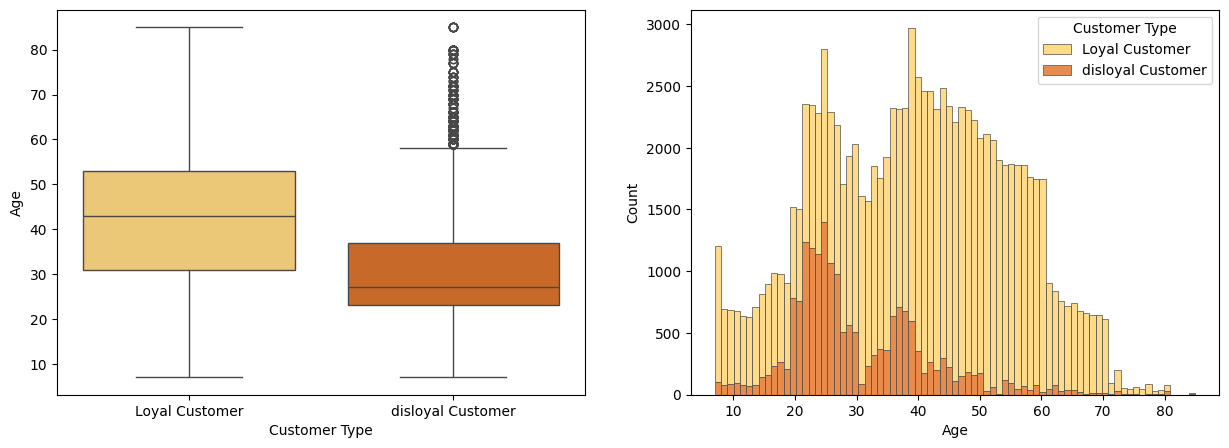

In [20]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "Customer Type", y = "Age", palette = "YlOrBr", data = data, ax = ax[0])
sns.histplot(data, x = "Age", hue = "Customer Type", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

From this box diagram, we can conclude that <b>most of the airline's regular customers are between the ages of 30 and 50 (their average age is slightly over 40)</b>. The age range of non-regular customers is slightly smaller (from 25 to 40 years old, on average - a little less than 30).

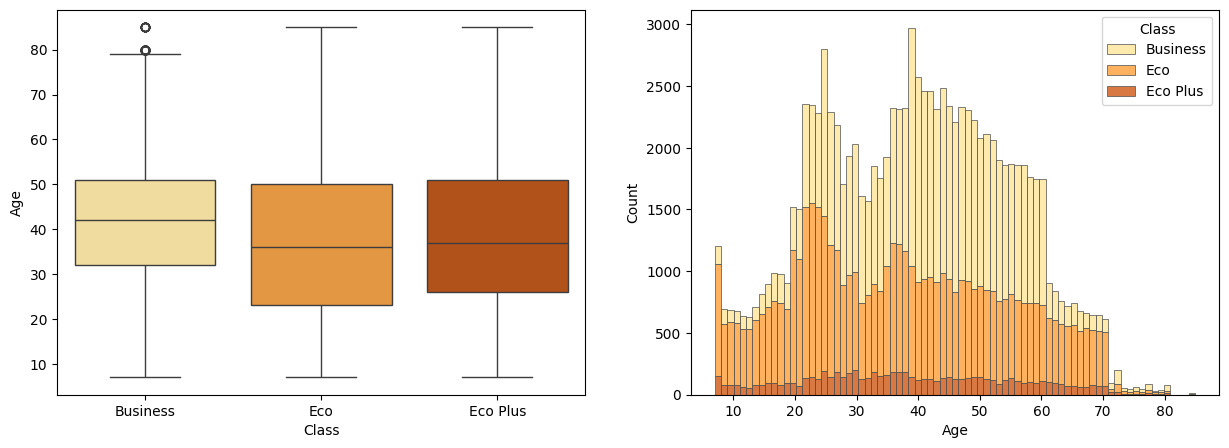

In [21]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "Class", y = "Age", palette = "YlOrBr", data = data, ax = ax[0])
sns.histplot(data, x = "Age", hue = "Class", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

It can be seen that, on average, the age range of those customers who travel in business class is the same (according to the previous box chart) as the age range of regular customers. Based on this observation, it can be assumed that <b>regular customers mainly buy business class for themselves</b>.

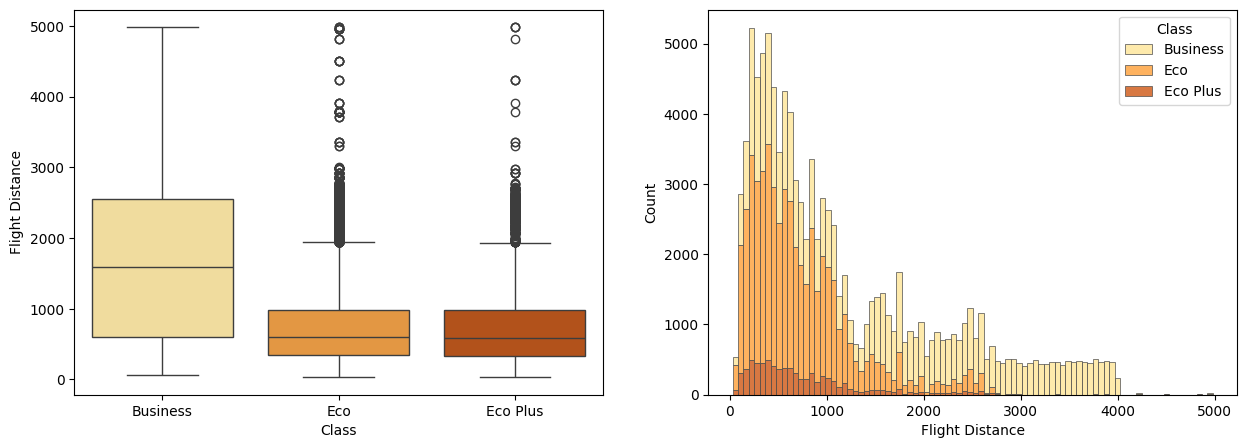

In [22]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "Class", y = "Flight Distance", palette = "YlOrBr", data = data, ax = ax[0])
sns.histplot(data, x = "Flight Distance", hue = "Class", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

From this box diagram, the following conclusion can be drawn: <b>customers whose flight distance is long, mostly fly in business class</b>.

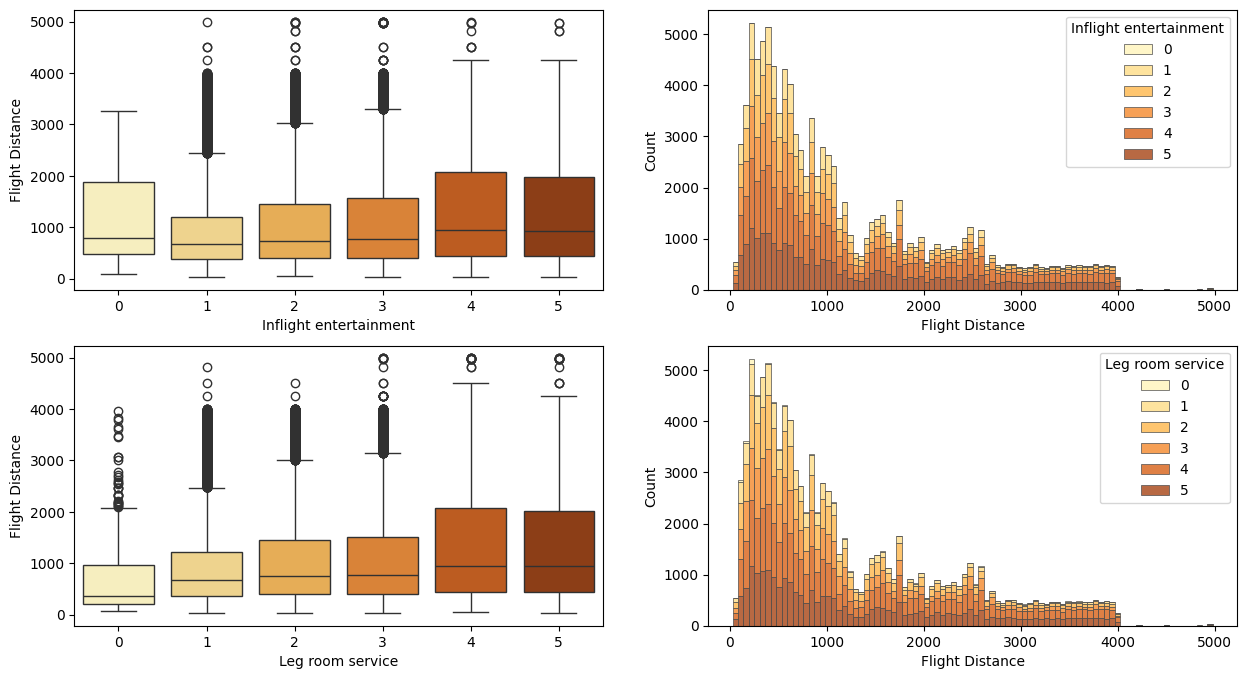

In [23]:
f, ax = plt.subplots(2, 2, figsize = (15,8))
sns.boxplot(x = "Inflight entertainment", y = "Flight Distance", palette = "YlOrBr", data = data, ax = ax[0, 0])
sns.histplot(data, x = "Flight Distance", hue = "Inflight entertainment", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[0, 1])
sns.boxplot(x = "Leg room service", y = "Flight Distance", palette = "YlOrBr", data = data, ax = ax[1, 0])
sns.histplot(data, x = "Flight Distance", hue = "Leg room service", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1, 1])
pass

The following pattern can be seen: <b>the more distance an aircraft passenger travels (respectively, the longer they are in flight), the more they are satisfied with the entertainment in flight and the extra legroom (on average)</b>.

Now consider the dependence graphs of some categorical features on the target - <em>satisfaction of air passengers</em>:

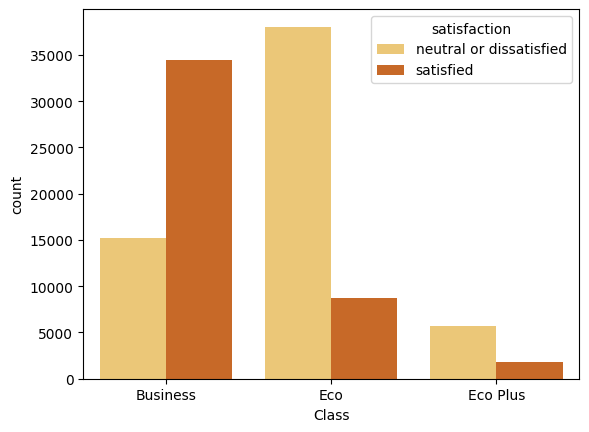

In [24]:
sns.countplot(x = 'Class', hue = 'satisfaction', palette = "YlOrBr", data = data)
plt.show()

This chart is very revealing. You can see that <b>most of the passengers who flew in economy plus or economy class were dissatisfied with the flight, and those who were lucky enough to fly in business class were satisfied</b>.

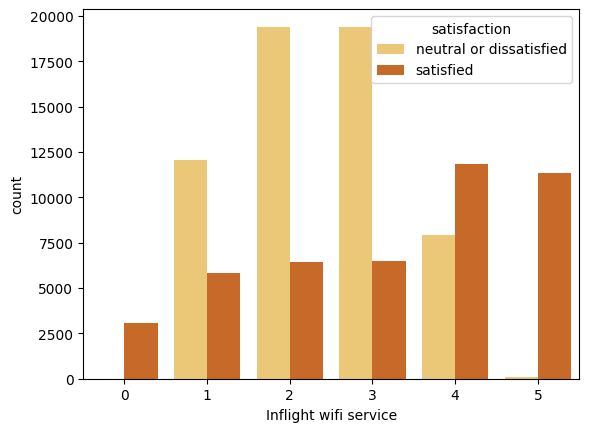

In [25]:
sns.countplot(x = 'Inflight wifi service', hue = 'satisfaction', palette = "YlOrBr", data = data)
plt.show()

According to this graph, you can see that <b>almost all passengers who rated the wifi service 5 out of 5 points were satisfied with the flight</b>.

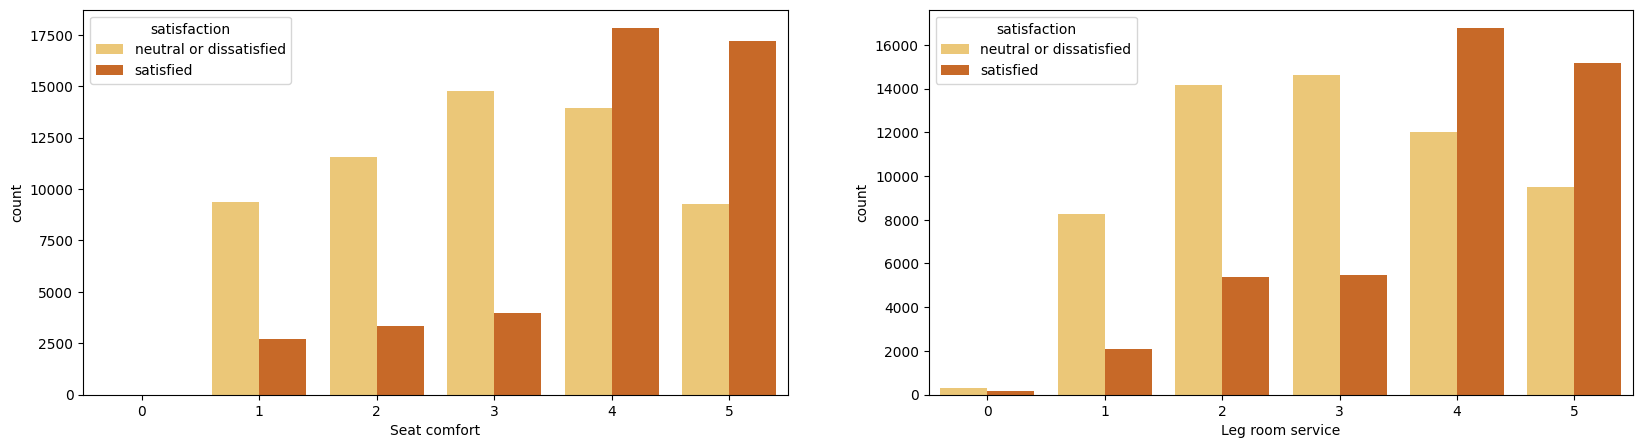

In [26]:
f, ax = plt.subplots(1, 2, figsize = (20,5))
sns.countplot(x = 'Seat comfort', hue = 'satisfaction', palette = "YlOrBr", data = data,ax = ax[0])
sns.countplot(x = 'Leg room service', hue = 'satisfaction', palette = "YlOrBr", data = data, ax = ax[1])
plt.show()


From the graphs above, we can conclude the following: <b>most passengers who rated the comfort of the seats and the extra legroom at 4 and 5 points out of 5 were satisfied with the flight</b>.

## Feature Engineering
### Filling in Missing Values

Let's see how many missing values are in each column of the table:

In [27]:
data.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

Fill in the missing values with <b>medians</b> in the columns corresponding to quantitative features:

In [28]:
data['Arrival Delay in Minutes'].fillna(data['Arrival Delay in Minutes'].median(axis = 0), inplace = True)

In [29]:
data.isna().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

In [30]:
data.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,14.815618,15.133392
std,15.114964,997.147281,38.230901,38.649776
min,7.000000,31.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000
50%,40.000000,843.000000,0.000000,0.000000
75%,51.000000,1743.000000,12.000000,13.000000
max,85.000000,4983.000000,1592.000000,1584.000000


This table shows that there are no more missing values.

### Handling Categorical Features

We divide the signs into quantitative and categorical:

In [31]:
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'category']
numerical_columns.remove('satisfaction')
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'category']
data_describe = data.describe(include = ['category'])

We divide categorical features into binary and non-binary:

In [32]:
binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['Gender', 'Customer Type', 'Type of Travel'] ['Class', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']


Let's look at the unique values for each binary feature:

In [33]:
for col in binary_columns:
    print(col, ': ', end = '')
    for uniq in data[col].unique():
        if uniq == data[col].unique()[-1]:
            print(uniq, end = '.')
        else:
            print(uniq, end = ', ')
    print()

Gender : Male, Female.
Customer Type : Loyal Customer, disloyal Customer.
Type of Travel : Personal Travel, Business travel.


Let's do the binarization:

In [34]:
data[col] == uniq

0         False
1          True
2          True
3          True
4          True
          ...  
103899     True
103900     True
103901     True
103902     True
103903     True
Name: Type of Travel, Length: 103904, dtype: bool

In [35]:
for col in binary_columns:
    data[col] = data[col].astype('object')
    k = 0
    for uniq in data[col].unique():
        data.loc[data[col] == uniq, col] = k
        k +=1 
for col in binary_columns:
    print(data[col].describe(), end = '\n\n')

count     103904
unique         2
top            1
freq       52727
Name: Gender, dtype: int64

count     103904
unique         2
top            0
freq       84923
Name: Customer Type, dtype: int64

count     103904
unique         2
top            1
freq       71655
Name: Type of Travel, dtype: int64



Now let's look at non-binary categorical features:

In [36]:
data[nonbinary_columns]

,Class,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
0,Eco Plus,3,4,3,1,5,3,5,5,4,3,4,4,5,5
1,Business,3,2,3,3,1,3,1,1,1,5,3,1,4,1
2,Business,2,2,2,2,5,5,5,5,4,3,4,4,4,5
3,Business,2,5,5,5,2,2,2,2,2,5,3,1,4,2
4,Business,3,3,3,3,4,5,5,3,3,4,4,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,Eco,2,1,2,3,2,2,2,2,3,1,4,2,3,2
103900,Business,4,4,4,4,2,4,5,5,5,5,5,5,5,4
103901,Business,1,1,1,3,4,1,5,4,3,2,4,5,5,4
103902,Eco,1,1,1,5,1,1,1,1,4,5,1,5,4,1


The following vectorization method is applicable to non-binary features:

The feature j, which takes s values, will be replaced by s features, which take the values 0 or 1, depending on what the value of the original feature j is.

This vectorization is carried out by the get_dummies method:

In [37]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['Class_Business', 'Class_Eco', 'Class_Eco Plus',
       'Inflight wifi service_0', 'Inflight wifi service_1',
       'Inflight wifi service_2', 'Inflight wifi service_3',
       'Inflight wifi service_4', 'Inflight wifi service_5',
       'Departure/Arrival time convenient_0',
       'Departure/Arrival time convenient_1',
       'Departure/Arrival time convenient_2',
       'Departure/Arrival time convenient_3',
       'Departure/Arrival time convenient_4',
       'Departure/Arrival time convenient_5', 'Ease of Online booking_0',
       'Ease of Online booking_1', 'Ease of Online booking_2',
       'Ease of Online booking_3', 'Ease of Online booking_4',
       'Ease of Online booking_5', 'Gate location_0', 'Gate location_1',
       'Gate location_2', 'Gate location_3', 'Gate location_4',
       'Gate location_5', 'Food and drink_0', 'Food and drink_1',
       'Food and drink_2', 'Food and drink_3', 'Food and drink_4',
       'Food and drink_5', 'Online boarding_0', 'Online board

In [38]:
len(data_nonbinary.columns)

86

### Normalization of Quantitative Features

We have the following quantitative characteristics:

In [39]:
data_numerical = data[numerical_columns]
data_numerical.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,14.815618,15.133392
std,15.114964,997.147281,38.230901,38.649776
min,7.000000,31.000000,0.000000,0.000000
25%,27.000000,414.000000,0.000000,0.000000
50%,40.000000,843.000000,0.000000,0.000000
75%,51.000000,1743.000000,12.000000,13.000000
max,85.000000,4983.000000,1592.000000,1584.000000


Let's perform a <b>standardization</b> (<em>linear transformation that reduces all values to zero mean and one standard deviation</em>) of all quantitative features:

In [40]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [41]:
data_numerical.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
count,1.039040e+05,1.039040e+05,1.039040e+05,1.039040e+05
mean,-2.549034e-17,8.000991e-17,1.853221e-17,1.463429e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.142229e+00,-1.161763e+00,-3.875299e-01,-3.915519e-01
25%,-8.190365e-01,-7.776668e-01,-3.875299e-01,-3.915519e-01
50%,4.103839e-02,-3.474395e-01,-3.875299e-01,-3.915519e-01
75%,7.687940e-01,5.551353e-01,-7.364771e-02,-5.519805e-02
max,3.018221e+00,3.804405e+00,4.125418e+01,4.059187e+01


### Table Formation

We join all the transformed columns into one table:

In [42]:
target = data['satisfaction']
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)

(103904, 93)


Now it looks like this:

In [43]:
data.describe()

,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes,Class_Business,Class_Eco,Class_Eco Plus,Inflight wifi service_0,Inflight wifi service_1,Inflight wifi service_2,...,Inflight service_2,Inflight service_3,Inflight service_4,Inflight service_5,Cleanliness_0,Cleanliness_1,Cleanliness_2,Cleanliness_3,Cleanliness_4,Cleanliness_5
count,1.039040e+05,1.039040e+05,1.039040e+05,1.039040e+05,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,...,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,-2.549034e-17,8.000991e-17,1.853221e-17,1.463429e-17,0.477989,0.449886,0.072124,0.029864,0.171697,0.248595,...,0.110265,0.195363,0.365193,0.260972,0.000115,0.128176,0.155259,0.236507,0.261578,0.218365
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.499518,0.497485,0.258695,0.170213,0.377119,0.432200,...,0.313222,0.396482,0.481487,0.439167,0.010746,0.334287,0.362153,0.424939,0.439496,0.413138
min,-2.142229e+00,-1.161763e+00,-3.875299e-01,-3.915519e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.190365e-01,-7.776668e-01,-3.875299e-01,-3.915519e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.103839e-02,-3.474395e-01,-3.875299e-01,-3.915519e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.687940e-01,5.551353e-01,-7.364771e-02,-5.519805e-02,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,3.018221e+00,3.804405e+00,4.125418e+01,4.059187e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Splitting Data for Training and Test Sets

Get <b>X</b> and <b>y</b>:

In [44]:
X = data
y = target
N, d = X.shape
N, d

(103904, 93)

In [45]:
X.columns

Index(['Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Class_Business', 'Class_Eco',
       'Class_Eco Plus', 'Inflight wifi service_0', 'Inflight wifi service_1',
       'Inflight wifi service_2', 'Inflight wifi service_3',
       'Inflight wifi service_4', 'Inflight wifi service_5',
       'Departure/Arrival time convenient_0',
       'Departure/Arrival time convenient_1',
       'Departure/Arrival time convenient_2',
       'Departure/Arrival time convenient_3',
       'Departure/Arrival time convenient_4',
       'Departure/Arrival time convenient_5', 'Ease of Online booking_0',
       'Ease of Online booking_1', 'Ease of Online booking_2',
       'Ease of Online booking_3', 'Ease of Online booking_4',
       'Ease of Online booking_5', 'Gate location_0', 'Gate location_1',
       'Gate location_2', 'Gate location_3', 'Gate location_4',
       'Gate location_5', 'Food and drink_0', 'Food and drink_1',
       'Food and drink_2', 'Food and 

In [46]:
y

0         neutral or dissatisfied
1         neutral or dissatisfied
2                       satisfied
3         neutral or dissatisfied
4                       satisfied
                   ...           
103899    neutral or dissatisfied
103900                  satisfied
103901    neutral or dissatisfied
103902    neutral or dissatisfied
103903    neutral or dissatisfied
Name: satisfaction, Length: 103904, dtype: object

Let's split the data into training and test samples in a ratio of 9:1 <b>(90% - training sample, 10% - test)</b>:

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 777)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(93513, 10391)

## Experimentation

### K Nearest Neighbors (KNN)

Let's train and run kNN for the 10 number of neighbors:

In [48]:
knn = KNeighborsClassifier()

knn.set_params(n_neighbors = 10)
knn.fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.05251676237528472
Error on the test sample:  0.06544124723318256


### Support Vector Classification (SVC)

Let's train and run the SVC:

In [49]:
svc = SVC(gamma = 'auto')
svc.fit(X_train, y_train)

err_train = np.mean(y_train != svc.predict(X_train))
err_test  = np.mean(y_test  != svc.predict(X_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.04966154438420327
Error on the test sample:  0.050235780964296026


### Random Forest

Train and run random forest:

In [50]:
rf = ensemble.RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  1.069370034112904e-05
Error on the test sample:  0.03868732557020498


### Extremely Randomized Trees

Train and run an extreme random forest:

In [51]:
ert = ensemble.ExtraTreesClassifier(n_estimators = 100).fit(X_train, y_train)

err_train = np.mean(y_train != ert.predict(X_train))
err_test  = np.mean(y_test  != ert.predict(X_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.0
Error on the test sample:  0.03907227408334135


### AdaBoost

Let's train and run the AdaBoost algorithm:

In [52]:
ada = ensemble.AdaBoostClassifier(n_estimators = 100)
ada.fit(X_train, y_train)

err_train = np.mean(y_train != ada.predict(X_train))
err_test = np.mean(y_test != ada.predict(X_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.0702576112412178
Error on the test sample:  0.07160042344336445


### Gradient-Boosted Tree (GBT)

Train and run gradient boosting decision trees:

In [53]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 100)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test = np.mean(y_test != gbt.predict(X_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.055286430763637144
Error on the test sample:  0.056394957174477914


## General Conclusions

<dl>
    <dt><h3>Conclusions About the Considered Sample</h3></dt>
    <dd>The sample is more or less balanced <em>(56.7% on 43.3%)</em>.</dd>
    <dd>The number of men and women in this sample is approximately the same.</dd>
    <dd>The vast majority of the airline's customers are repeat customers.</dd>
    <dd>Most of our clients flew for business rather than personal reasons.</dd>
    <dd>About half of the passengers were in business class.</dd>
    <dd>More than 60% of passengers were satisfied with the luggage transportation service (rating 4-5 out of 5).</dd>
    <dd>More than 50% of passengers were comfortable sitting in their seats (rated 4-5 out of 5).</dd>
    <dd>There was a strong correlation <em>(96%)</em> between the features 'Departure delay in minutes' and 'Arrival delay in minutes' (which is quite logical and was discussed in detail above).</dd>
    <dd>Most of the airline's regular customers are between the ages of 30 and 50 (averaging a little over 40). The age range for non-regular customers is slightly smaller (from 25 to 40 years old, with an average of slightly less than 30).</dd>
    <dd>Customers whose flight distance is long tend to fly in business class.</dd>
    <dd>The more distance an airplane passenger travels (respectively, the longer they are in flight), the more satisfied they are with in-flight entertainment and extra legroom (on average).</dd>
    <dd>Most of the passengers who flew in Economy Plus or Economy Class were dissatisfied with the flight, and those who were lucky enough to fly in Business Class were satisfied.</dd>
    <dd>Almost all passengers who rated the wifi service 5 out of 5 were satisfied with the flight.</dd>
    <dd>The majority of passengers who rated the comfort of the seats and the extra legroom at 4 and 5 points out of 5 were satisfied with the flight.
</dl>
<dl>
    <dt><h3>Conclusions on Classification Results</h3></dt>
    <dd>For the kNN method, the error on the training set was <em>5.2%</em>, and on the test set it was <em>6.5%</em>.</dd>
    <dd>For the support vector machine, the error on both the training and test sets was <em>5%</em>.</dd>
    <dd>For the Random Forest and Extreme Random Forest classifiers, the error on the training set was not observed, but on the test set it was <em>3.9%</em>.</dd>
    <dd>For the AdaBoost algorithm, the error on the training set was <em>7%</em>, and on the test set it was <em>7.2%</em>.</dd>
    <dd>For gradient boosted decision trees, the error on the training and test samples was <em>5.5% and 5.6%</em> respectively.</dd>
    <dd>The classifiers Random and Extremely Random Forest showed the best result (the error on the test sample is <em>3.9%).</em></dd>
</dl>